## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set01 known vehicle, known attack)

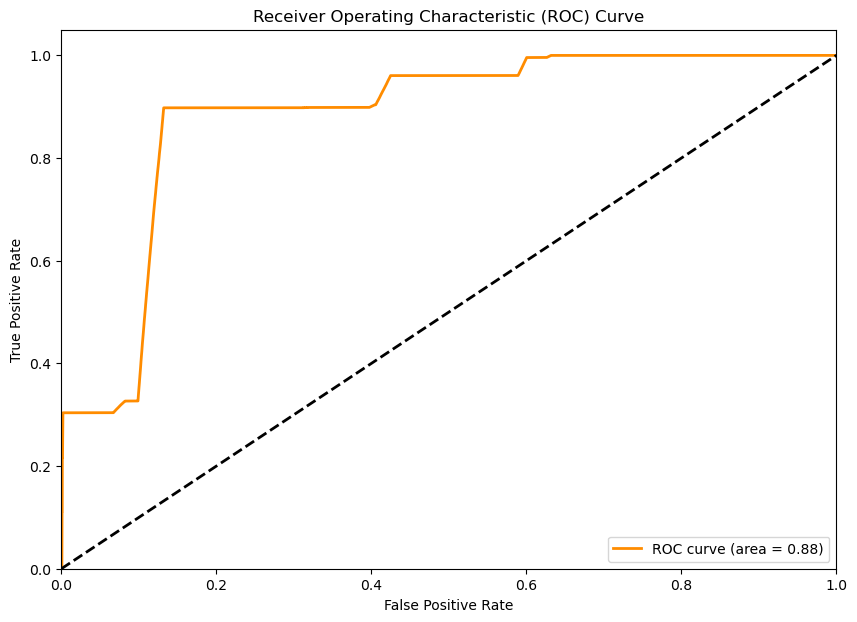

AUC: 0.8830
Accuracy: 0.7298
Precision: 0.9877
Recall: 0.7298
F1-score: 0.8334
Training Time: 13.6005 seconds
Testing Time: 0.7353 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.84   5639390
           1       0.04      0.90      0.07     63280

    accuracy                           0.73   5702670
   macro avg       0.52      0.81      0.46   5702670
weighted avg       0.99      0.73      0.83   5702670



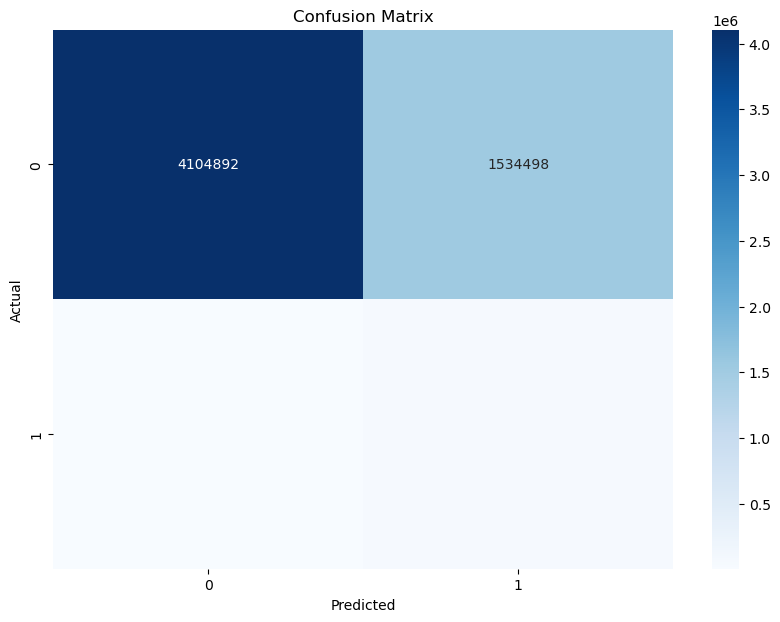

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set01 unknown vehicle, known attack)

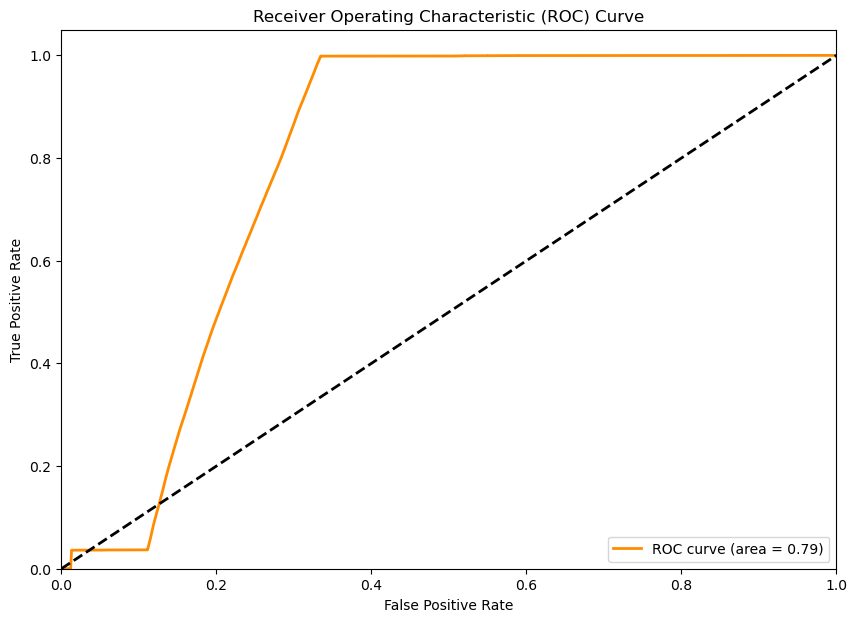

AUC: 0.7932
Accuracy: 0.6161
Precision: 0.9761
Recall: 0.6161
F1-score: 0.7385
Training Time: 16.7729 seconds
Testing Time: 0.8229 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.61      0.75   6283750
           1       0.06      1.00      0.12    164167

    accuracy                           0.62   6447917
   macro avg       0.53      0.80      0.44   6447917
weighted avg       0.98      0.62      0.74   6447917



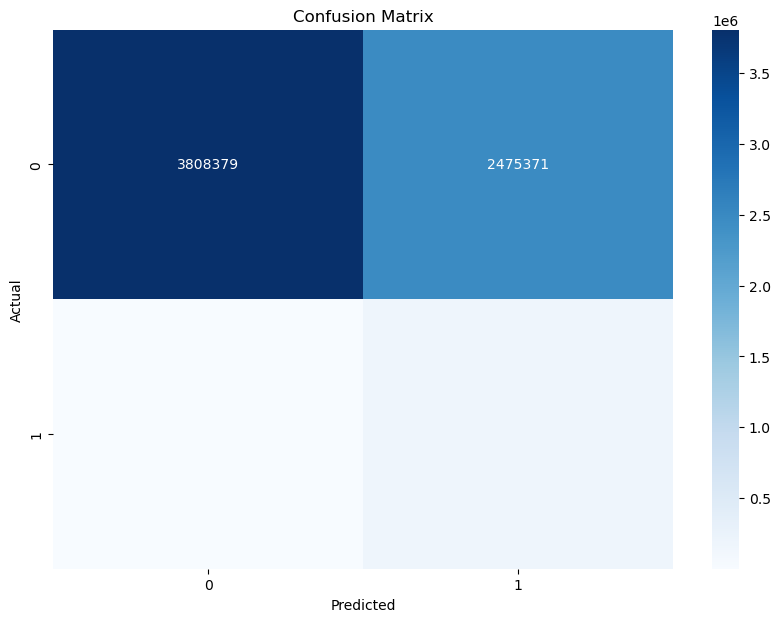

In [6]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set01 test03 known vehicle, unknown attack)

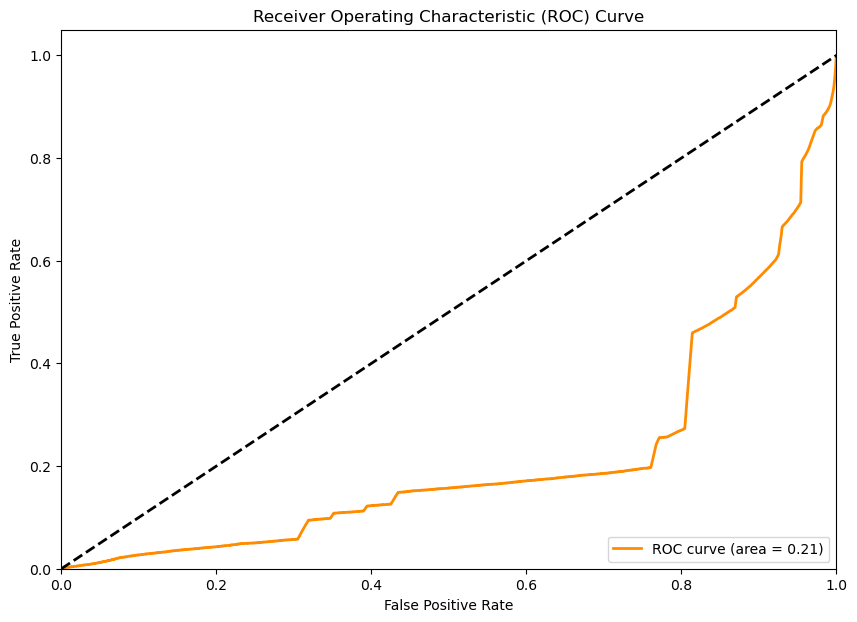

AUC: 0.2123
Accuracy: 0.7325
Precision: 0.9945
Recall: 0.7325
F1-score: 0.8435
Training Time: 12.7919 seconds
Testing Time: 0.5582 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.85   8614450
           1       0.00      0.05      0.00     20825

    accuracy                           0.73   8635275
   macro avg       0.50      0.39      0.42   8635275
weighted avg       0.99      0.73      0.84   8635275



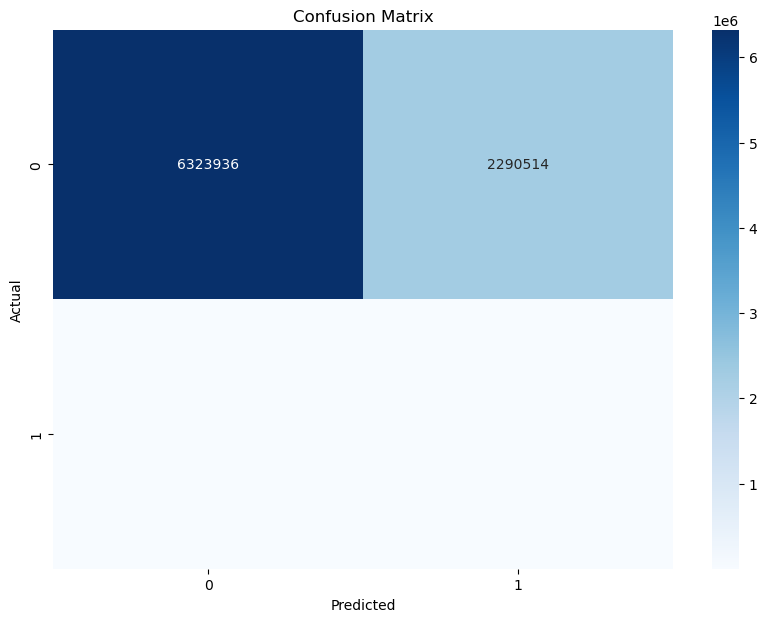

In [7]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set01 test04 unknown vehicle, unknown attack)

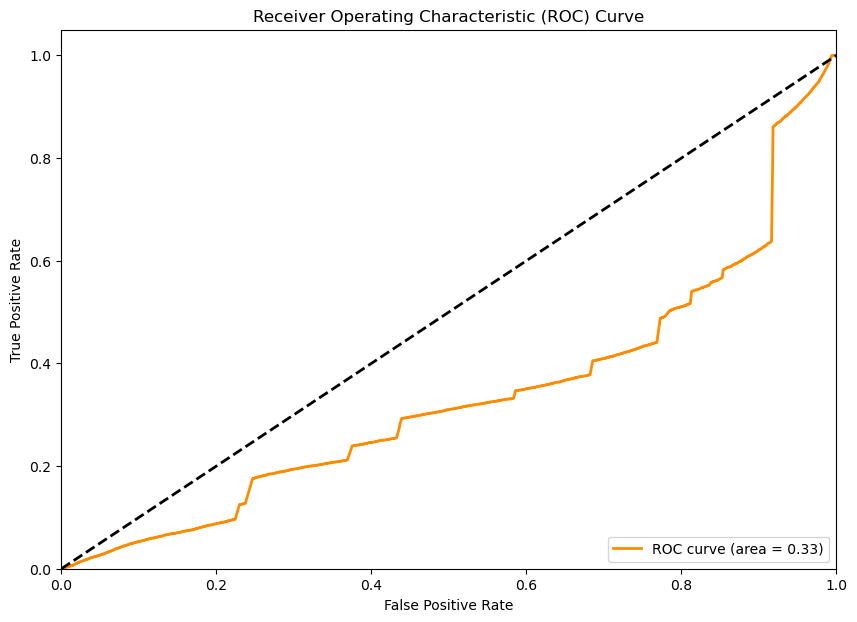

AUC: 0.3331
Accuracy: 0.7904
Precision: 0.9977
Recall: 0.7904
F1-score: 0.8820
Training Time: 13.0684 seconds
Testing Time: 1.1986 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88  13206311
           1       0.00      0.09      0.00     14244

    accuracy                           0.79  13220555
   macro avg       0.50      0.44      0.44  13220555
weighted avg       1.00      0.79      0.88  13220555



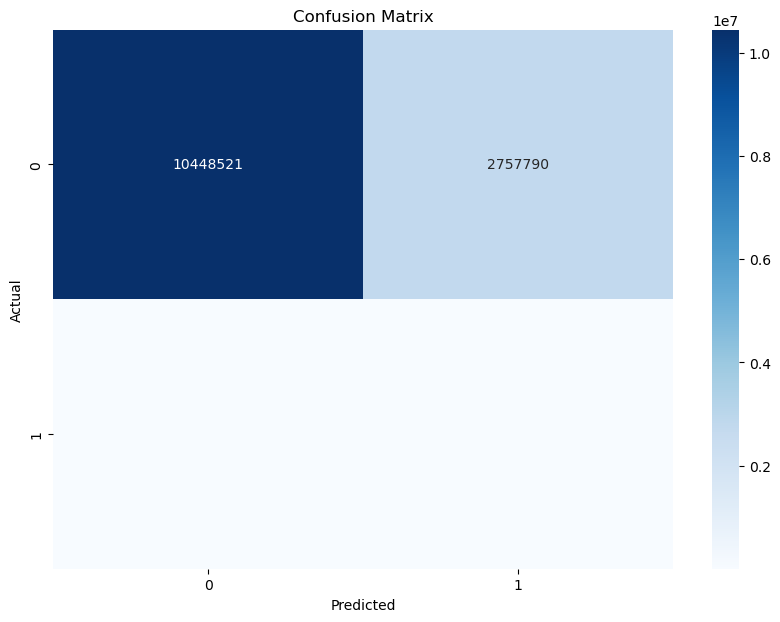

In [8]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set01 test 01 known vehicle, known attack)

Accuracy: 0.9889
Precision: 0.9779
Recall: 0.9889
F1-score: 0.9834
ROC AUC: 0.5000
Training Time: 408.0566 seconds
Testing Time: 141.7491 seconds


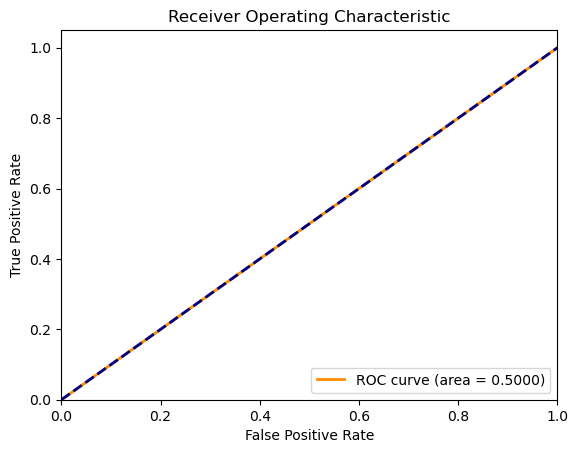

In [2]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set01 test 02 unknown vehicle, known attack)

Accuracy: 0.9745
Precision: 0.9497
Recall: 0.9745
F1-score: 0.9620
ROC AUC: 0.5000
Training Time: 453.7315 seconds
Testing Time: 321.6386 seconds


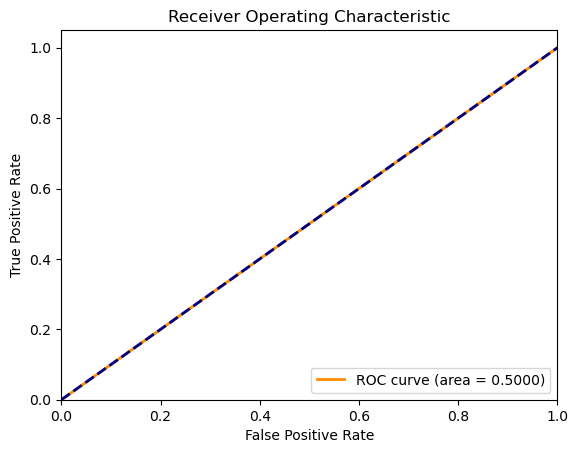

In [9]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set01 test 03 known vehicle, unknown attack)

Accuracy: 0.9976
Precision: 0.9976
Recall: 0.9976
F1-score: 0.9964
ROC AUC: 0.5002
Training Time: 412.8343 seconds
Testing Time: 221.4952 seconds


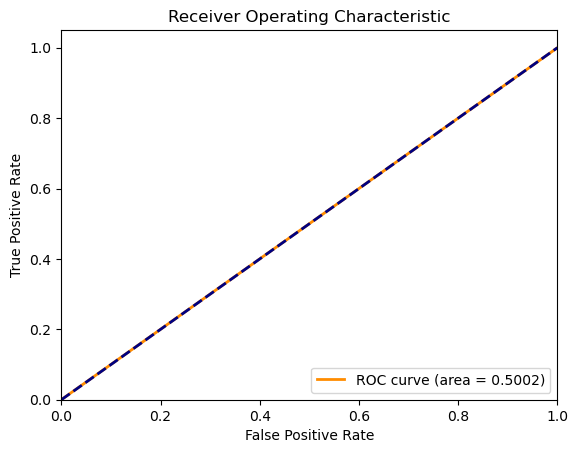

In [10]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set01 test 04 unknown vehicle, unknown attack)

Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F1-score: 0.9984
ROC AUC: 0.5002
Training Time: 501.6205 seconds
Testing Time: 239.1830 seconds


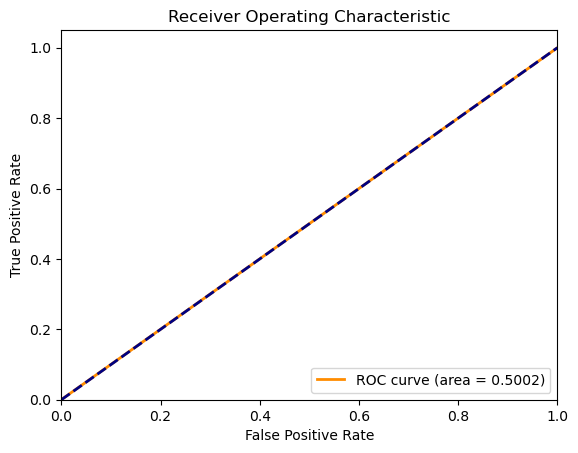

In [11]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set01 test 01 known vehicle, known attack)

Accuracy: 0.9916
Precision: 0.9917
Recall: 0.9916
F1-score: 0.9891
Training Time: 41.2449 seconds
Testing Time: 408.9802 seconds


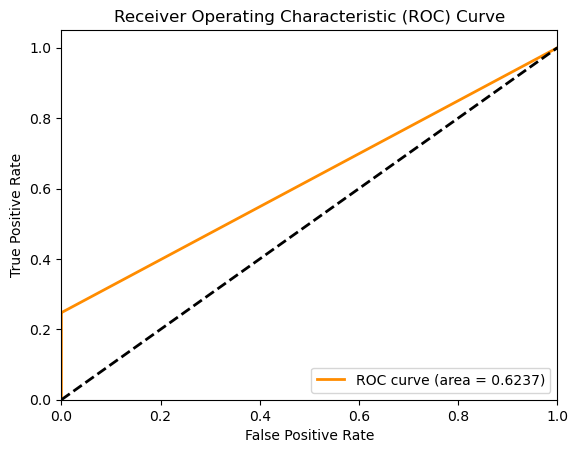

AUC: 0.6237


In [7]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set01 test 02 unknown vehicle, known attack)

Accuracy: 0.9719
Precision: 0.9497
Recall: 0.9719
F1-score: 0.9607
Training Time: 43.3908 seconds
Testing Time: 719.4022 seconds


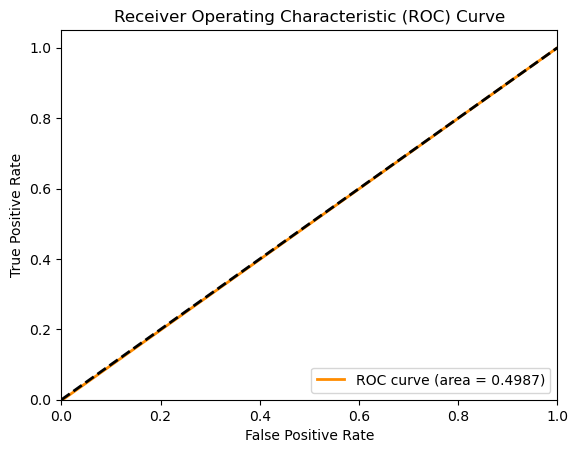

AUC: 0.4987


In [12]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set01 test 03 known vehicle, unknown attack)

Accuracy: 0.9976
Precision: 0.9976
Recall: 0.9976
F1-score: 0.9964
Training Time: 57.3858 seconds
Testing Time: 1154.8891 seconds


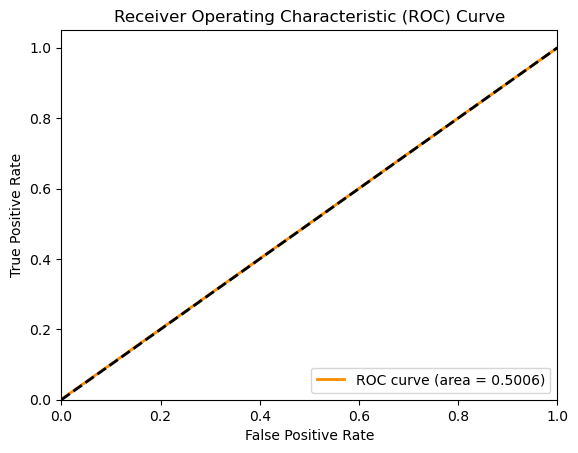

AUC: 0.5006


In [13]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set01 test 04 unknown vehicle, unknown attack)

Accuracy: 0.9985
Precision: 0.9978
Recall: 0.9985
F1-score: 0.9982
Training Time: 55.0056 seconds
Testing Time: 1808.7876 seconds


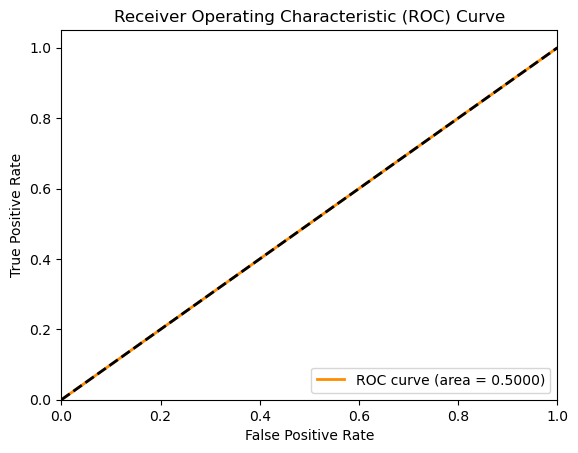

AUC: 0.5000


In [14]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set01 test01 known vehicle, known attack)

Accuracy: 0.9927
Precision: 0.9927
Recall: 0.9927
F1-score: 0.9909
Training Time: 665.7416 seconds
Testing Time: 4.9621 seconds


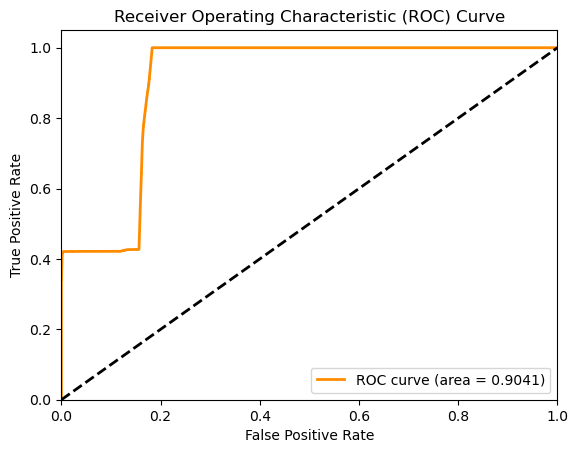

AUC: 0.9041


In [9]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set01 test 02 unknown vehicle, known attack)

Accuracy: 0.9726
Precision: 0.9494
Recall: 0.9726
F1-score: 0.9609
Training Time: 359.0286 seconds
Testing Time: 7.3541 seconds


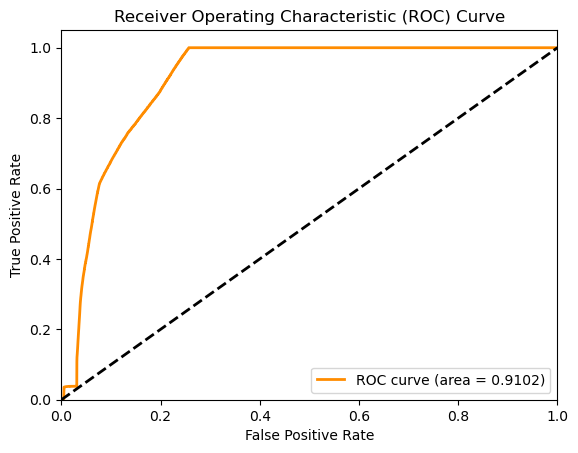

AUC: 0.9102


In [15]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set01 test 03 known vehicle, unknown attack)

Accuracy: 0.9974
Precision: 0.9957
Recall: 0.9974
F1-score: 0.9964
Training Time: 433.8576 seconds
Testing Time: 9.6902 seconds


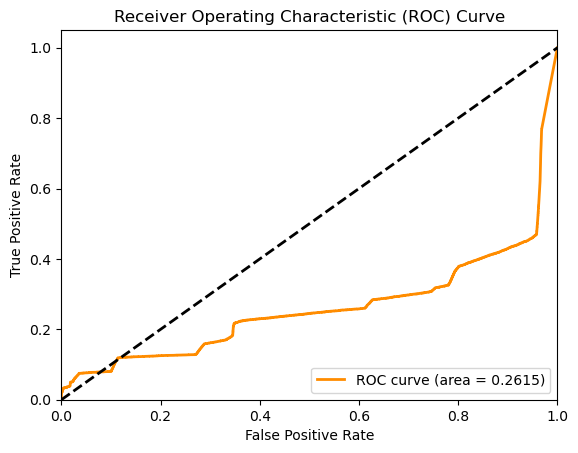

AUC: 0.2615


In [16]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set01 test 04 unknown vehicle, unknown attack)

Accuracy: 0.9981
Precision: 0.9979
Recall: 0.9981
F1-score: 0.9980
Training Time: 394.3318 seconds
Testing Time: 95.8665 seconds


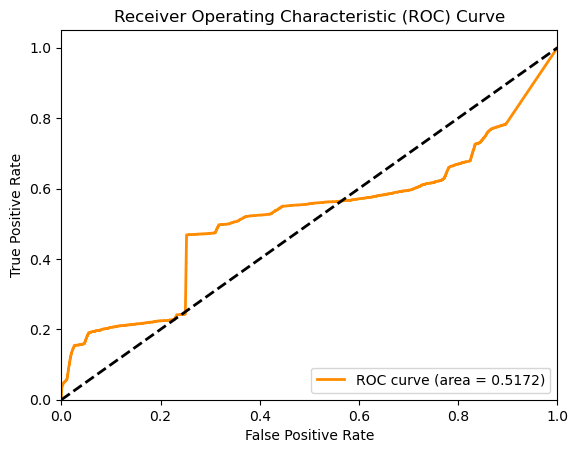

AUC: 0.5172


In [17]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set01 test 01 known vehicle, known attack)


Decision Tree Results
Accuracy: 0.9916
Precision: 0.9917
Recall: 0.9916
F1-score: 0.9891
Training Time: 42.1310 seconds
Testing Time: 1.8949 seconds


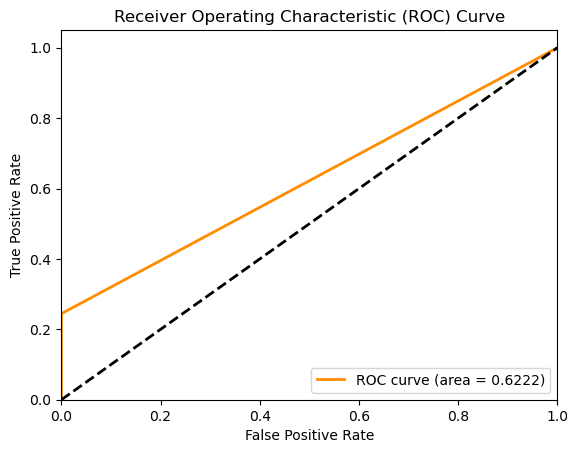

AUC: 0.6222


In [18]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set01 test 02 unknown vehicle, known attack)


Decision Tree Results
Accuracy: 0.9460
Precision: 0.9827
Recall: 0.9460
F1-score: 0.9591
Training Time: 41.7586 seconds
Testing Time: 2.2430 seconds


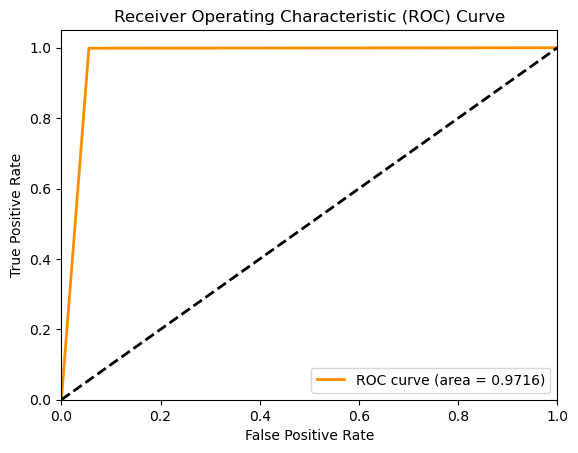

AUC: 0.9716


In [19]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set01 test 03 known vehicle, unknown attack)


Decision Tree Results
Accuracy: 0.9976
Precision: 0.9976
Recall: 0.9976
F1-score: 0.9965
Training Time: 44.9012 seconds
Testing Time: 3.2269 seconds


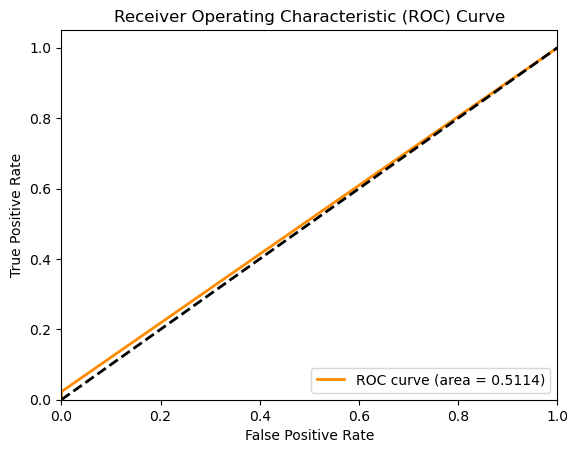

AUC: 0.5114


In [20]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set01 test 04 unknown vehicle, unknown attack)


Decision Tree Results
Accuracy: 0.9986
Precision: 0.9980
Recall: 0.9986
F1-score: 0.9983
Training Time: 43.5623 seconds
Testing Time: 3.4798 seconds


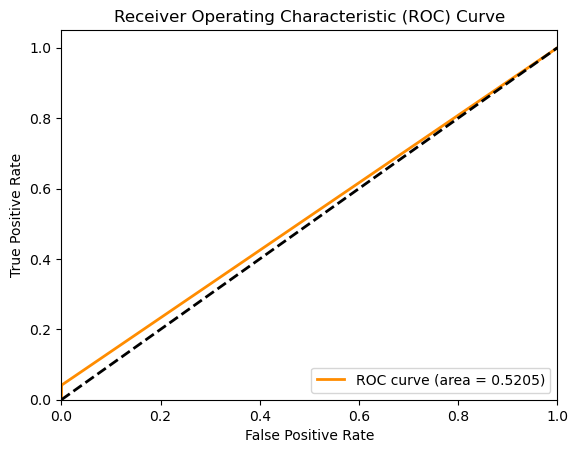

AUC: 0.5205


In [21]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_01\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))
